In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.10.0
Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras.utils import load_img, img_to_array
from keras_preprocessing.image import load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
Image_Size = 256
Batch_Size = 32

In [4]:
image_dataset_training = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train",
    image_size=(Image_Size, Image_Size),
    batch_size= Batch_Size,
    shuffle=True
)

Found 6552 files belonging to 102 classes.


In [5]:
image_dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/valid",
    image_size=(Image_Size, Image_Size),
    batch_size= Batch_Size,
    shuffle=True
)

Found 818 files belonging to 102 classes.


In [35]:
folder_path = "dataset/test"
image_list = []

image_list = []
for fname in os.listdir(folder_path):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(folder_path, fname)
        img = load_img(img_path, target_size=(Image_Size, Image_Size))
        img_array = img_to_array(img)
        image_list.append(img_array)

# Convert list to NumPy array for prediction
image_dataset_test = np.array(image_list)

In [36]:
image_dataset_test = image_dataset_test / 255.0

In [12]:
with open("dataset/class_order.json", "w") as f:
    json.dump(image_dataset_training.class_names, f)

In [13]:
for image_batch, labels_batch in image_dataset_training.take(1):
    print(image_batch.shape)
    print(labels_batch)

(32, 256, 256, 3)
tf.Tensor(
[ 81  49  96  72  89  24  96  67  72  56  32  91  43  93  59  90  35  74
  41  78  15 100  52  43  43 101  44  79  84  23  47  11], shape=(32,), dtype=int32)


In [14]:
for image_batch, label_batch in image_dataset_training.take(1):
    print(image_batch[0].numpy())

[[[245.81041   249.28697   157.85338  ]
  [223.04155   228.51811   133.56499  ]
  [194.82812   200.82812   102.468475 ]
  ...
  [ 14.1640625  40.943497    1.0837097]
  [ 16.81688    43.81688     0.7270355]
  [ 19.521484   47.029297    0.7488556]]

 [[245.72662   251.43999   153.4288   ]
  [242.71591   248.92348   148.8917   ]
  [226.35577   233.0515    130.12726  ]
  ...
  [ 15.08049    39.384766    2.8734589]
  [ 17.00586    41.798294    3.125534 ]
  [ 21.378906   46.665543    4.234375 ]]

 [[244.78516   251.78516   147.70717  ]
  [242.53207   249.71916   143.7938   ]
  [240.39685   248.18523   137.87077  ]
  ...
  [ 14.794815   35.432907    4.975769 ]
  [ 21.149979   42.29924     7.9160156]
  [ 27.994003   49.60756    10.994003 ]]

 ...

 [[ 99.92232   117.05095    22.237183 ]
  [121.66818   129.6506     55.3304   ]
  [195.2198    190.72508   142.60283  ]
  ...
  [163.21384   201.21384    81.65387  ]
  [ 82.10744   121.10744     4.631592 ]
  [ 73.02248   112.02248     0.       ]]

 [

In [15]:
image_dataset_training = image_dataset_training.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
image_dataset_validation = image_dataset_validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_Size, Image_Size),
    layers.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [18]:
input_shape = (Image_Size, Image_Size, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# adding new custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # to prevent overfitting
output = Dense(102, activation='softmax')(x)  # Output layer with 102 classes

# Fine-tune half layers
fine_tune_at = len(base_model.layers)//2
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# model creation
pre_trained_model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 [==============================] - 4s 0us/step


In [19]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [22]:
pre_trained_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# reduce LR when val_loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [23]:
pre_trained_history = pre_trained_model.fit(
    image_dataset_training,
    epochs=30,
    batch_size=Batch_Size,
    validation_data=image_dataset_validation,
    callbacks = [reduce_lr]
)

Epoch 1/30
205/205 [==============================] - 97s 292ms/step - loss: 1.8852 - accuracy: 0.5546 - val_loss: 1.8829 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 2/30
205/205 [==============================] - 55s 267ms/step - loss: 0.4221 - accuracy: 0.8773 - val_loss: 1.0858 - val_accuracy: 0.7543 - lr: 0.0010
Epoch 3/30
205/205 [==============================] - 55s 268ms/step - loss: 0.1312 - accuracy: 0.9654 - val_loss: 0.5102 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 4/30
205/205 [==============================] - 55s 267ms/step - loss: 0.0790 - accuracy: 0.9760 - val_loss: 0.5829 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 5/30
205/205 [==============================] - 55s 268ms/step - loss: 0.0619 - accuracy: 0.9835 - val_loss: 0.3354 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 6/30
205/205 [==============================] - 55s 267ms/step - loss: 0.0534 - accuracy: 0.9850 - val_loss: 0.7505 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 7/30
205/205 [==============================] 

In [24]:
model_version = 1
pre_trained_model.save(f"models/pre_trained_flower_classification_model_v{model_version}.h5")

In [37]:
Epochs = pre_trained_history.epoch
acc = pre_trained_history.history['accuracy']
val_acc = pre_trained_history.history['val_accuracy']

loss = pre_trained_history.history['loss']
val_loss = pre_trained_history.history['val_loss']

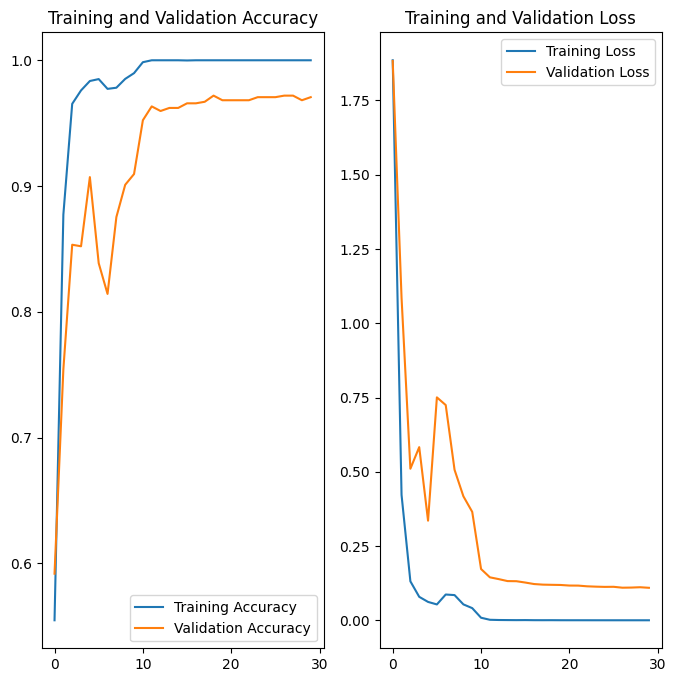

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(Epochs, acc, label='Training Accuracy')
plt.plot(Epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(Epochs, loss, label='Training Loss')
plt.plot(Epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

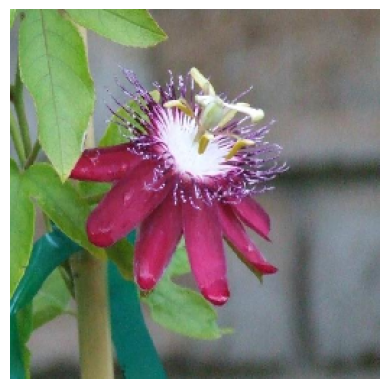

In [39]:
plt.imshow(image_dataset_test[10])
plt.axis("off")
plt.show()

In [40]:
first_image = image_dataset_test[10]            # Extract the first image

first_image_batch = np.expand_dims(first_image, axis=0)  # Add batch dimension

prediction = pre_trained_model.predict(first_image_batch)

1/1 [==============================] - 2s 2s/step


In [41]:
# Load mappings
with open("dataset/cat_to_name.json", "r") as f:
    class_names = json.load(f)

with open("dataset/class_order.json", "r") as f:
    class_order = json.load(f)

1/1 [==============================] - 0s 35ms/step


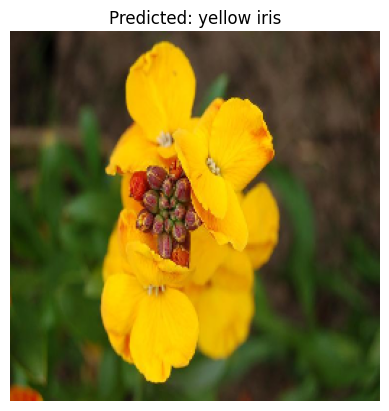

In [42]:
first_image = image_dataset_test[100]
first_image_batch = np.expand_dims(first_image, axis=0)
prediction = pre_trained_model.predict(first_image_batch)

# Get the predicted class name
predicted_class = class_names[f"{np.argmax(prediction)}"]

# Show the image with predicted label
plt.imshow(image_dataset_test[100])
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()